In [1]:
# Additional torch-related imports
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
    BCELoss
)
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
# Necessary imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss, BCELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
# Set seed for random generators
algorithm_globals.random_seed = 42

In [3]:
df = pd.read_csv('features_3_sec.csv')
df

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,66149,0.255331,0.080393,0.032510,0.000075,1599.272683,1.856708e+04,1675.591596,20596.85173,2928.515625,...,55.257095,-1.666343,104.916260,4.525014,69.806412,-0.897889,110.099175,4.160629,194.109070,classical
1,66149,0.231431,0.084894,0.031453,0.000059,1551.352817,2.852497e+04,1485.790068,28831.79451,2623.655161,...,50.988071,-1.546098,65.954590,7.157280,69.336983,2.718532,120.725609,-1.692275,150.527496,classical
2,66149,0.225458,0.082233,0.041776,0.000222,1466.237496,4.501883e+04,1495.076539,10600.32107,2536.280048,...,81.254791,-4.686039,102.037117,-4.411082,60.409714,-2.694283,60.788319,3.038420,213.015579,classical
3,66149,0.260866,0.082233,0.032749,0.000136,1435.850575,3.227031e+04,1585.998216,36208.01670,2673.678448,...,40.191471,2.764065,46.115536,-0.732678,60.197281,-8.223904,64.066719,1.734897,119.727020,classical
4,66149,0.269611,0.084948,0.045156,0.000476,1477.712706,2.144815e+04,1569.311614,20844.07851,2783.580604,...,62.712025,-0.079564,89.584717,2.686025,65.182037,-1.290078,105.829987,-4.315813,79.882378,classical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,66149,0.342589,0.089339,0.137082,0.002701,3210.404285,5.229747e+05,3518.891658,106856.50710,8172.595966,...,55.283569,1.613460,56.897308,6.900325,95.293251,-0.688965,37.893326,5.038363,56.635410,pop
1994,66149,0.324163,0.096156,0.151230,0.001677,2584.693526,5.699567e+05,3274.529361,135583.64630,6815.755709,...,49.914917,3.775996,73.963264,12.763522,150.864807,7.824332,220.597992,11.147660,241.048462,pop
1995,66149,0.347829,0.102577,0.130131,0.002049,2732.619962,9.389428e+05,3305.178275,228680.15840,7076.307467,...,37.255424,0.172578,43.497780,2.358351,79.210114,5.260961,137.600296,9.504729,119.177002,pop
1996,66149,0.353859,0.092972,0.148098,0.001058,2891.360207,1.304064e+06,3344.280322,165330.74760,7360.048828,...,57.142181,2.004879,86.238083,4.730950,161.434052,10.439860,157.169983,9.645600,124.777672,pop


In [11]:
for column in df.columns:
    if df[column].dtype != 'object':  # Check if column is numeric
        df[column] = df[column] / df[column].abs().max()

df.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,1.0,0.345713,0.705434,0.073458,0.002418,0.324788,0.006233,0.451868,0.020810,0.308673,...,0.080793,-0.063708,0.198193,0.122396,0.110851,-0.030433,0.096305,0.116738,0.263260,classical
1,1.0,0.313353,0.744932,0.071069,0.001916,0.315057,0.009576,0.400683,0.029130,0.276540,...,0.074551,-0.059110,0.124592,0.193595,0.110106,0.092142,0.105600,-0.047482,0.204153,classical
2,1.0,0.305266,0.721580,0.094395,0.007202,0.297771,0.015113,0.403187,0.010710,0.267330,...,0.118805,-0.179157,0.192754,-0.119314,0.095930,-0.091320,0.053172,0.085252,0.288902,classical
3,1.0,0.353207,0.721580,0.073997,0.004395,0.291600,0.010833,0.427706,0.036582,0.281812,...,0.058765,0.105676,0.087115,-0.019818,0.095592,-0.278742,0.056040,0.048677,0.162380,classical
4,1.0,0.365048,0.745405,0.102031,0.015417,0.300101,0.007200,0.423206,0.021059,0.293396,...,0.091693,-0.003042,0.169231,0.072654,0.103508,-0.043726,0.092571,-0.121092,0.108340,classical


In [12]:
# Separate features and labels (assuming the last column is the label)
x = df.iloc[:, :-1].values  # All columns except the last
labels = df.iloc[:, -1].values

encoder = LabelEncoder()
encoder.fit(labels)
y = encoder.transform(labels)

# convert into PyTorch tensors
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)


# Split data into training and testing sets (80% for training, 20% for testing)
test_size = 0.2  # Adjust as needed
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=test_size, random_state=42)
X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)


batch_size = 4
train_loader = DataLoader(list(zip(X_train, y_train)), shuffle=True, batch_size=batch_size)
test_loader = DataLoader(list(zip(X_test, y_test)), shuffle=True, batch_size=batch_size)

# Print the shapes of training and testing sets for verification
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: torch.Size([1598, 1, 58])
X_test shape: torch.Size([400, 1, 58])
y_train shape: torch.Size([1598, 1])
y_test shape: torch.Size([400, 1])


In [37]:
# Define and create QNN
def create_qnn():
    feature_map = ZZFeatureMap(2, reps=1)
    ansatz = RealAmplitudes(2, reps=1)
    qc = QuantumCircuit(2)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn


qnn4 = create_qnn()

In [38]:
import torch
from torch import nn

class MyImprovedCNN(nn.Module):
  def __init__(self, input_channels=1, output_channels=8, kernel_size=3):
    super(MyImprovedCNN, self).__init__()

    # Customizable hyperparameters
    self.input_channels = input_channels
    self.output_channels = output_channels
    self.kernel_size = kernel_size

    # Convolutional layers with padding and ReLU activation
    self.conv1 = nn.Conv1d(self.input_channels, self.output_channels,
                            kernel_size=self.kernel_size, padding=1)
    self.relu1 = nn.ReLU(inplace=True)

    # Optional second convolutional layer (uncomment if needed)
    # self.conv2 = nn.Conv1d(self.output_channels, self.output_channels * 2,
    #                       kernel_size=self.kernel_size, padding=1)
    # self.relu2 = nn.ReLU(inplace=True)

    # Max pooling layer
    self.pool1 = nn.MaxPool1d(kernel_size=2)

    # Flatten the output before fully connected layers
    self.flatten = nn.Flatten()

    # Fully connected layer with customizable neurons
    self.fc1 = nn.Linear(232, 128)  # Calculate output size after pooling
    self.relu3 = nn.ReLU(inplace=True)

    # Output layer with 1 neuron for binary classification
    self.fc2 = nn.Linear(128, 1)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.pool1(x)

    # Uncomment for optional second convolutional layer
    # x = self.conv2(x)
    # x = self.relu2(x)
    # x = self.pool1(x)

    x = self.flatten(x)
    x = self.fc1(x)
    x = self.relu3(x)
    x = self.fc2(x)
    # Apply sigmoid activation for binary classification (optional)
    x = torch.sigmoid(x)  # Output between 0 and 1
    return x

# Example usage
model4 = MyImprovedCNN()

In [39]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model4.parameters(), lr=0.1)
loss_func = BCELoss()

# Start training
epochs = 10 # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(X_batch)  # Forward pass
        loss = loss_func(output, y_batch)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

Training [10%]	Loss: 0.2029
Training [20%]	Loss: 0.2212
Training [30%]	Loss: 0.1328
Training [40%]	Loss: 0.1161
Training [50%]	Loss: 0.1443
Training [60%]	Loss: 0.1312
Training [70%]	Loss: 0.1038
Training [80%]	Loss: 0.1175
Training [90%]	Loss: 0.1254
Training [100%]	Loss: 0.1202


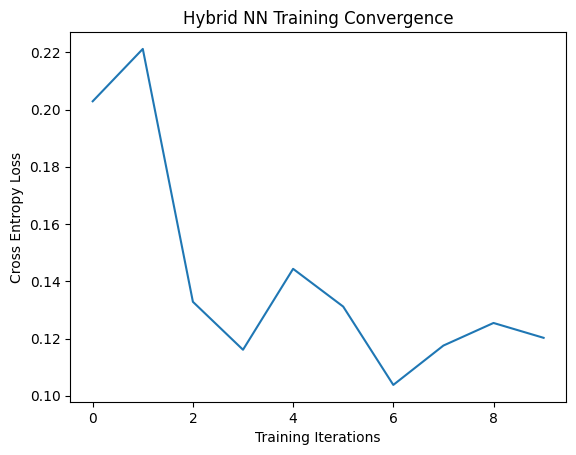

In [40]:
# Plot loss convergence
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Cross Entropy Loss")
plt.show()

In [43]:
model4.eval()
# Evaluation loop
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model4(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        # Convert labels back to original binary values
        original_labels = encoder.inverse_transform(predicted.numpy())
        # Check accuracy based on binary labels
        correct += (original_labels == 'your_positive_label').sum().item()  # Replace 'your_positive_label' with your actual positive label

# Calculate accuracy
accuracy = correct / total
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 0.00%


In [44]:
model4.eval()
# Evaluation loop
correct = 0
total = 0
with torch.no_grad():
    for images, labels in train_loader:
        outputs = model4(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        # Convert labels back to original binary values
        original_labels = encoder.inverse_transform(predicted.numpy())
        # Check accuracy based on binary labels
        correct += (original_labels == 'your_positive_label').sum().item()  # Replace 'your_positive_label' with your actual positive label

# Calculate accuracy
accuracy = correct / total
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 0.00%
